In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima

In [2]:
# 1. Load and preprocess data
file_path = "/Users/alonclausen/Desktop/Studie/Kandidat/Seminar/SEMINARFIN/fulldata.csv"
data = pd.read_csv(file_path)

# Parse 'from' column as datetime and set as index
data['from'] = pd.to_datetime(data['from'], utc=True).dt.tz_localize(None)
data.set_index('from', inplace=True)
data = data.sort_index()

# Replace zeros with forward-filled values
spot_price = data['SpotPriceDKK'].replace(0, pd.NA).ffill()

/var/folders/jg/p6c6lqr91kj2q41htjb2tvsc0000gn/T/ipykernel_36938/1256737850.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  spot_price = data['SpotPriceDKK'].replace(0, pd.NA).ffill()


In [3]:
# 2. Define the training and test periods
train_start, train_end = pd.to_datetime('2017-10-27'), pd.to_datetime('2024-07-31')
test_start, test_end = pd.to_datetime('2024-08-01'), pd.to_datetime('2024-11-29')

train_data = spot_price.loc[train_start:train_end]
test_data = spot_price.loc[test_start:test_end]

forecast_horizon = 24  # Forecast 24 hours ahead


In [4]:
# 3. Determine the best ARIMA order (if not already known)
#    We'll use data up to 24 hours before test start for model selection
initial_training_end = test_start - pd.Timedelta(hours=24)
initial_training_data = spot_price.loc[train_start:initial_training_end]

stepwise_model = auto_arima(
    initial_training_data, 
    start_p=0, start_q=0, max_p=5, max_q=5, 
    seasonal=False, stepwise=True, trace=True,
    error_action='ignore', suppress_warnings=True
)
best_order = stepwise_model.order
best_seasonal_order = (0, 0, 0, 0)

print(f"Selected ARIMA order: {best_order}")

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=735387.072, Time=0.60 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=724352.532, Time=0.66 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=725640.091, Time=1.85 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=735385.073, Time=0.29 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=724141.889, Time=0.83 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=722805.108, Time=1.70 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=721672.428, Time=2.22 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=720557.656, Time=3.50 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=717687.621, Time=29.71 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=717750.542, Time=29.57 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=717749.833, Time=87.90 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=717788.631, Time=66.18 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=717685.615, Time=10.44 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=717748.544, Time=7.16 sec


In [11]:
# 4. Fit the model once on initial training data
model = SARIMAX(
    initial_training_data,
    order=(4,1,0), 
    seasonal_order=(0,0,0,0),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


In [12]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:           SpotPriceDKK   No. Observations:                59257
Model:               SARIMAX(4, 1, 0)   Log Likelihood             -360807.504
Date:                Mon, 16 Dec 2024   AIC                         721625.009
Time:                        12:40:48   BIC                         721669.956
Sample:                    10-27-2017   HQIC                        721638.978
                         - 07-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4074      0.001    349.296      0.000       0.405       0.410
ar.L2          0.0062      0.002      4.060      0.000       0.003       0.009
ar.L3         -0.0905      0.002    -49.308      0.0

In [ ]:
# 4. Fit a SARIMAX model with the chosen order on the initial training data
model = SARIMAX(initial_training_data, 
                order=(best_order), 
                seasonal_order=best_seasonal_order,
                enforce_stationarity=False, 
                enforce_invertibility=False)
results = model.fit(disp=False)

# 5. Rolling Forecast Loop
forecast_times = pd.date_range(start=test_start, 
                               end=test_end - pd.Timedelta(hours=forecast_horizon - 1), freq='H')

predictions = []
actuals = []

for current_time in forecast_times:
    # Define the end of the available data for updating the model
    data_end_time = current_time - pd.Timedelta(hours=24)
    last_model_time = results.model.data.orig_endog.index[-1]

    # Append new data to the model if available
    if data_end_time > last_model_time:
        new_data = spot_price.loc[last_model_time + pd.Timedelta(hours=1):data_end_time]
        if not new_data.empty:
            results = results.append(new_data, refit=False)

    # Forecast the next 24 hours
    forecast = results.get_forecast(steps=forecast_horizon)
    forecast_values = forecast.predicted_mean

    forecast_index = pd.date_range(start=current_time, periods=forecast_horizon, freq='H')
    forecast_series = pd.Series(forecast_values.values, index=forecast_index)
    actual_series = spot_price.loc[current_time:current_time + pd.Timedelta(hours=forecast_horizon - 1)]

    # Align forecasts with actuals
    common_index = forecast_series.index.intersection(actual_series.index)
    predictions.append(forecast_series.loc[common_index])
    actuals.append(actual_series.loc[common_index])

# Concatenate predictions and actuals
predictions = pd.concat(predictions)
actuals = pd.concat(actuals)


/var/folders/jg/p6c6lqr91kj2q41htjb2tvsc0000gn/T/ipykernel_36938/1438634123.py:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_exog_index = pd.date_range(start=forecast_start - pd.Timedelta(hours=24),


NameError: name 'exog_selected' is not defined

In [14]:
# 6. Evaluate the Forecast
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")

MAE: 309.2345, MSE: 174768.7057, RMSE: 418.0535


In [17]:
# Convert the forecast series to a numpy array
forecast_array = predictions.values

# Save the numpy array to a file named 'forecast_values.npy'
np.save('forecast_ARIMA.npy', forecast_array)

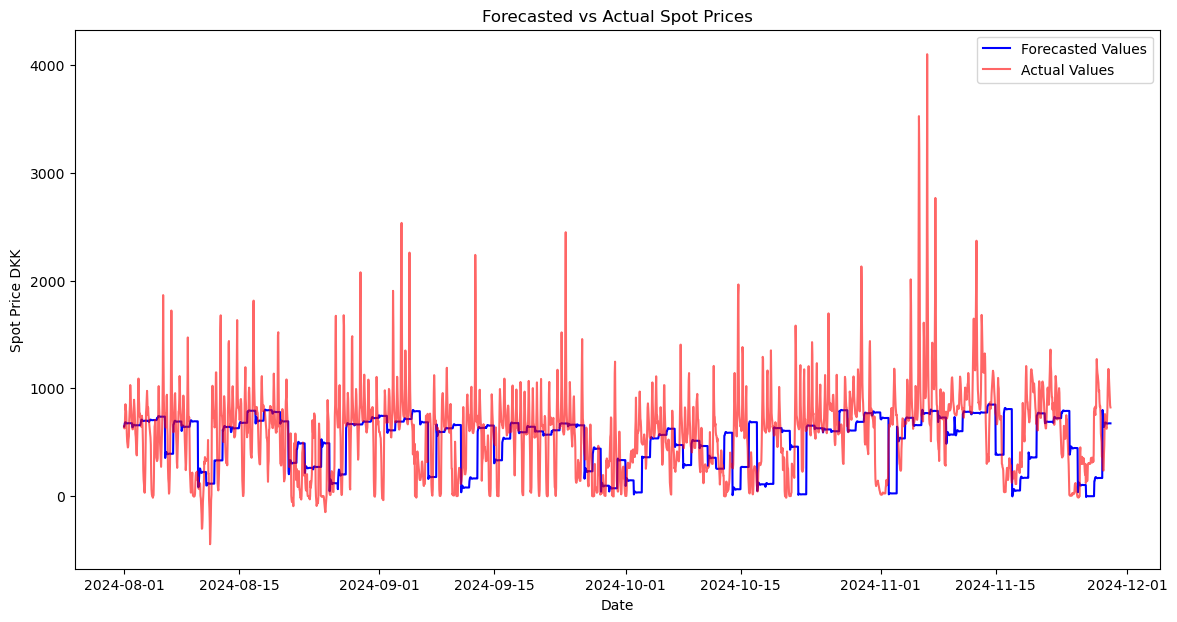

In [18]:
plt.figure(figsize=(14, 7))
plt.plot(predictions, label='Forecasted Values', color='blue')
plt.plot(actuals, label='Actual Values', color='red', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Spot Price DKK')
plt.title('Forecasted vs Actual Spot Prices')
plt.legend()
plt.show()